# Forecast Methods

**Table of Contents**

- [Method 1: Percent Over Last Year](#percentoverlastyear)
- [Method 2: Calculated Percent Over Last Year](#calculatedpercentoverlastyear)
- [Method 3: Last Year to This Year](#lastyeartothisyear)
- [Method 4: Moving Average](#movingaverage)
- [Method 5: Linear Approximation](#linearapproximation)
- [Method 6: Least Squares Regression](#leastsquaresregression)
- [Method 7: Second Degree Approximation](#seconddegreeapproximation)
- [Method 8: Flexible Method](#flexiblemethod)
- [Method 9: Weighted Moving Average](#weightedmovingaverage)
- [Method 10: Linear Smoothing](#linearsmoothing)
- [Method 11: Exponential Smoothing](#exponentialsmoothing)
- [Method 12: Exponential Smoothing with Trend and Seasonality](#expsmoothingwtrend)


In [ ]:
# Imports
from decimal import Decimal

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

/home/tyler/.cache/pypoetry/virtualenvs/forecast-k0gLrqvw-py3.8/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# Create dataset (DataFrame for presentation purposes)
one_year_ago = [128, 117, 115, 125, 122, 137, 140, 129, 131, 114, 119, 137]
two_years_ago = [125, 123, 115, 137, 122, 130, 141, 128, 118, 123, 139, 133]
cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

data = pd.DataFrame([one_year_ago, two_years_ago],
                    index=['n-1', 'n-2'],
                    columns=cols)

data.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
n-1,128,117,115,125,122,137,140,129,131,114,119,137
n-2,125,123,115,137,122,130,141,128,118,123,139,133


In [ ]:
# Helper function to create simple plots of historical and forecasted data

def make_plots(forecast_data, method_name):
    """
    Helper function to display two plots:
        - Left plot shows historical actual data as two lines on lineplot
        - Right plot shows forecasted data
    - Data is statically set to assume monthly inputs
    - Both plots are forced to the same y-scale, if forecasted values are
        above the ylim, they won't be visible on the plot
    
    :param forecast_data: Assumes numeric, monthly data
    :param method_name: string, used as plot title
    :return: None, displays plot in notebook
    """
    plt.subplots(figsize=(15, 6));
    
    # Create historical plot
    plt.subplot(1, 2, 1);
    plt.plot(cols, one_year_ago, 'ko--', label='One Yr Ago');
    plt.plot(cols, two_years_ago, 'o--', c='gray', label='Two Yrs Ago');
    plt.title('Historical');
    plt.ylabel('Sales');
    plt.ylim([110, 165]);
    plt.xlabel('Month');
    plt.legend(loc='lower right');
    
    # Create forecast plot
    plt.subplot(1, 2, 2);
    plt.plot(cols, forecast_data, 'go--', label='Next Year');
    plt.title(f'Forecast - {method_name}');
    plt.ylabel('Sales');
    plt.ylim([110, 165]);
    plt.xlabel('Month');
    plt.legend(loc='lower right');

## <a name="percentoverlastyear"></a>Method 1: Percent Over Last Year

This method multiplies each forecast period by a given, static growth/decline rate over the same period the year prior.

The example below applies a 10% growth rate to each monthly sales figure from the year prior to generate the forecast.

In [ ]:
percent_1 = Decimal(10)
print(f'Period growth rate: {percent_1:.2f}%')

# Apply rate to prior year's monthly data
percent_over_last_year = [Decimal(n) * (1 + percent_1 / 100) for n in one_year_ago]
percent_over_last_year

Period growth rate: 10.00%


[Decimal('140.8'),
 Decimal('128.7'),
 Decimal('126.5'),
 Decimal('137.5'),
 Decimal('134.2'),
 Decimal('150.7'),
 Decimal('154.0'),
 Decimal('141.9'),
 Decimal('144.1'),
 Decimal('125.4'),
 Decimal('130.9'),
 Decimal('150.7')]

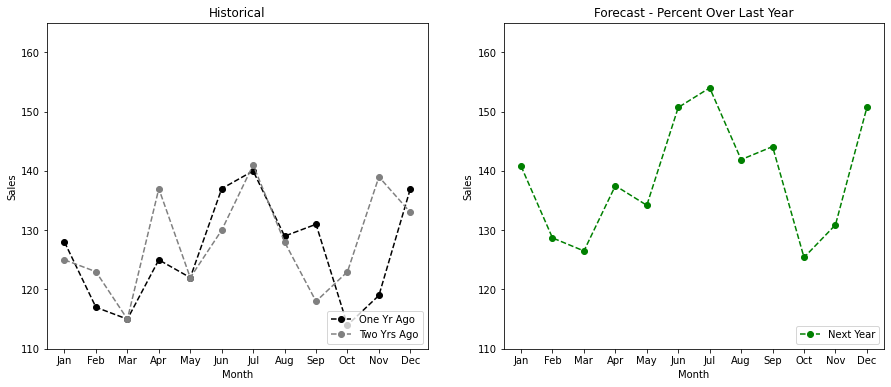

In [ ]:
make_plots(percent_over_last_year, 'Percent Over Last Year')

## <a name="calculatedpercentoverlastyear"></a> Method 2: Calculated Percent Over Last Year

This method calculates a period-over-period growth rate from a given slice of historical data. To generate the forecast, that rate is then applied to each period in the prior years historical data.

The example below uses Q4 sales from the prior two years of historical data to calculate the growth rate. It then applies that rate to each months sales figures from the last year to generate the monthly forecast data.

In [ ]:
periods_2 = 4

# Calculate the growth rate
n_minus_2_sales = sum(two_years_ago[-periods_2:])
n_minus_1_sales = sum(one_year_ago[-periods_2:])
percent_2 = Decimal((n_minus_1_sales / n_minus_2_sales - 1) * 100)
print(f'Period growth rate: {percent_2:.2f}%')

# Apply rate to prior year's monthly data
calculated_percent_over_last_year = [Decimal(n) * (1 + percent_2 / 100) for n in one_year_ago]
calculated_percent_over_last_year

Period growth rate: -2.34%


[Decimal('125.0058479532163744352146750'),
 Decimal('114.2631578947368422571884139'),
 Decimal('112.3099415204678364066381846'),
 Decimal('122.0760233918128656593893311'),
 Decimal('119.1461988304093568835639871'),
 Decimal('133.7953216374269007626907069'),
 Decimal('136.7251461988304095385160508'),
 Decimal('125.9824561403508773604897897'),
 Decimal('127.9356725146198832110400190'),
 Decimal('111.3333333333333334813630700'),
 Decimal('116.2163742690058481077386432'),
 Decimal('133.7953216374269007626907069')]

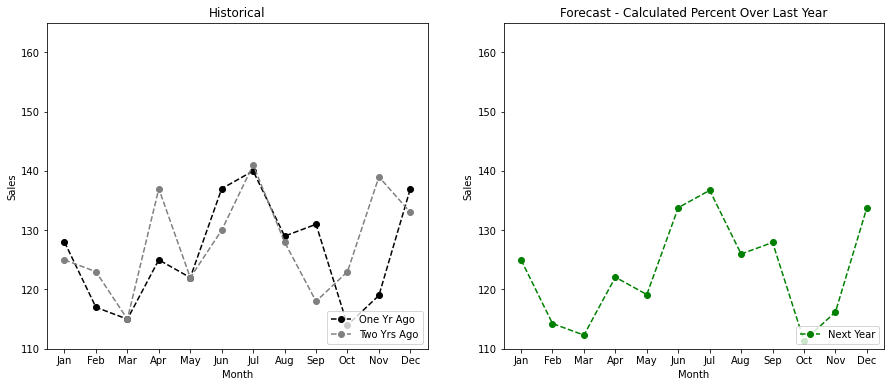

In [ ]:
make_plots(calculated_percent_over_last_year, 'Calculated Percent Over Last Year')

## <a name="lastyeartothisyear"></a>Method 3: Last Year to This Year

This method uses the same period data from the last year as the forecast for next year. Another way to look at it is that the forecast applies a 'percent over last year' growth rate of 0%.

In [ ]:
last_year_to_this_year = [Decimal(n) for n in one_year_ago]
last_year_to_this_year

[Decimal('128'),
 Decimal('117'),
 Decimal('115'),
 Decimal('125'),
 Decimal('122'),
 Decimal('137'),
 Decimal('140'),
 Decimal('129'),
 Decimal('131'),
 Decimal('114'),
 Decimal('119'),
 Decimal('137')]

In [ ]:
make_plots(last_year_to_this_year, 'Last Year to This Year')

NameError: name 'last_year_to_this_year' is not defined

## <a name="movingaverage"></a>Method 4: Moving Average

This method averages the prior given number of periods together to determine the next period's value.

The example below averages the prior 4 months of sales data to generate the current period's forecast. (Note: the example doesn't round the forecasted value each iteration).

In [ ]:
periods_4 = 4
moving_average = one_year_ago[-periods_4:]

# TODO: look into window function possibilities for arrays
# Generate forecast
for i in range(12):
    moving_average.append(Decimal(np.mean(moving_average[-periods_4:])))

# Remove the historical data needed for the first several forecast period calcs
del moving_average[:periods_4]

moving_average

[Decimal('125.25'),
 Decimal('123.8125'),
 Decimal('126.265625'),
 Decimal('128.08203125'),
 Decimal('125.8525390625'),
 Decimal('126.003173828125'),
 Decimal('126.55084228515625'),
 Decimal('126.6221466064453125'),
 Decimal('126.257175445556640625'),
 Decimal('126.35833454132080078125'),
 Decimal('126.4471247196197509765625'),
 Decimal('126.421195328235626220703125')]

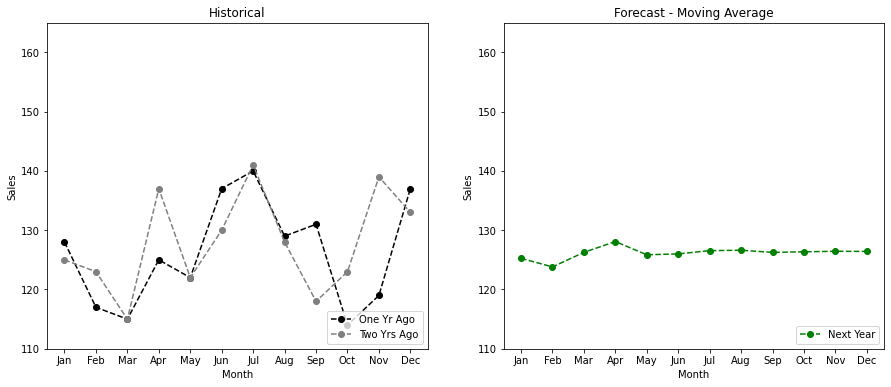

In [ ]:
make_plots(moving_average, "Moving Average")

## <a name="linearapproximation"></a>Method 5: Linear Approximation

This method calculates a slope (trend) from the endpoints of a given number of periods from historical data, then applies that trend to generate each period in the forecast.

The example below calculates a slope from the prior year's Q4 September and December monthly sales figures. That trend is extended for 12 periods to generate the forecast.

In [ ]:
periods_5 = 4

# Calculate the slope
slope_5 = Decimal((one_year_ago[-1] - one_year_ago[-(periods_5 + 1)]) / periods_5)
print(f'Slope: {slope_5:.2f}')

# Generate the forecast
linear_approximation = [Decimal(one_year_ago[-1]) + (slope_5 * (i + 1)) for i in range(len(one_year_ago))]
linear_approximation

Slope: 2.00


[Decimal('139'),
 Decimal('141'),
 Decimal('143'),
 Decimal('145'),
 Decimal('147'),
 Decimal('149'),
 Decimal('151'),
 Decimal('153'),
 Decimal('155'),
 Decimal('157'),
 Decimal('159'),
 Decimal('161')]

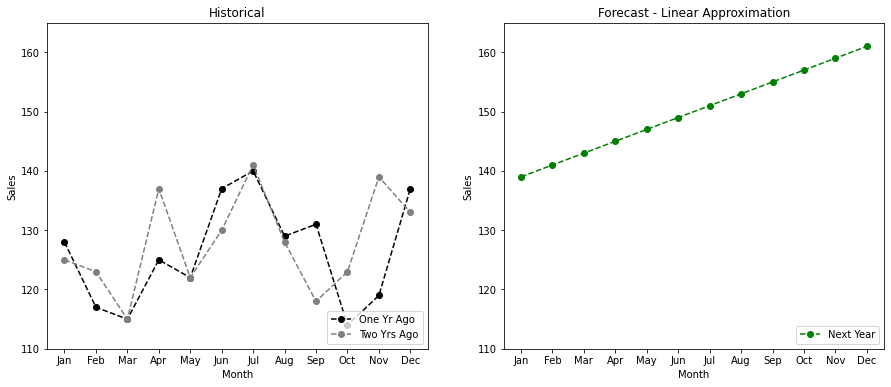

In [ ]:
make_plots(linear_approximation, 'Linear Approximation')

## <a name="leastsquaresregression"></a>Method 6: Least Squares Regression

This method finds a line of best fit via the Least Squares Method based on the given period of historical data. It then applies the resulting slope ($m$) and intercept ($b$) to generate the forecasted values with the formula $y = mx + b$.

In [ ]:
periods_6 = 4

# Format data for regression analysis
x_6 = range(1, periods_6 + 1)
y_6 = one_year_ago[-periods_6:]

# Perform Least Squares regression on given historical data
slope_6, intercept_6, r_value, p_value, std_err = stats.linregress(x_6, y_6)
print(f'Slope: {slope_6:.2f}, Intercept: {intercept_6:.2f}')  # 2.30, 119.50

# Generate forecast
least_squares_regression = [Decimal(i * slope_6 + intercept_6) for i in range(periods_6 + 1, periods_6 + 13)]
least_squares_regression

Slope: 2.30, Intercept: 119.50


[Decimal('131'),
 Decimal('133.30000000000001136868377216160297393798828125'),
 Decimal('135.599999999999994315658113919198513031005859375'),
 Decimal('137.900000000000005684341886080801486968994140625'),
 Decimal('140.19999999999998863131622783839702606201171875'),
 Decimal('142.5'),
 Decimal('144.80000000000001136868377216160297393798828125'),
 Decimal('147.099999999999994315658113919198513031005859375'),
 Decimal('149.400000000000005684341886080801486968994140625'),
 Decimal('151.69999999999998863131622783839702606201171875'),
 Decimal('154'),
 Decimal('156.30000000000001136868377216160297393798828125')]

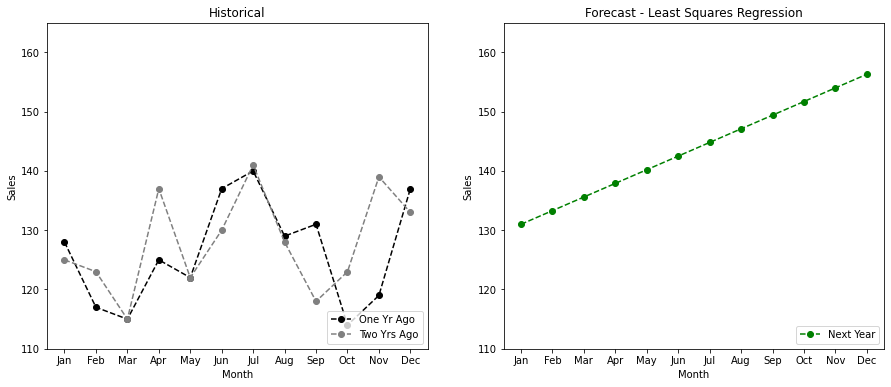

In [ ]:
make_plots(least_squares_regression, 'Least Squares Regression')

## <a name="seconddegreeapproximation"></a>Method 7: Second Degree Approximation

This method uses a set number of historic periods as input to fit a second-degree polynomial to the trend. The underlying math uses the historic data to fit a curve that solves the equation $y = a + bx + cx^2$.

The example below slices a 6-month period of recent monthly historic sales to establish the polynomial trend.

In [ ]:
periods_7 = 6

# Format data for curve fitting
x_7 = range(1, periods_7 + 1)
y_7 = one_year_ago[-periods_7:]

# Fit a 2nd degree polynomial
c, b, a = np.polyfit(x_7, y_7, deg=2)

# Generate forecast
per = range(periods_7 + 1, periods_7 + 13)
second_degree_approximation = [Decimal(a + b*x + c*x**2) for x in per]
second_degree_approximation

[Decimal('148.299999999999954525264911353588104248046875'),
 Decimal('168.957142857142798675340600311756134033203125'),
 Decimal('195.22142857142853245022706687450408935546875'),
 Decimal('227.092857142857127428214880637824535369873046875'),
 Decimal('264.57142857142861203101347200572490692138671875'),
 Decimal('307.6571428571429578369134105741977691650390625'),
 Decimal('356.350000000000136424205265939235687255859375'),
 Decimal('410.650000000000318323145620524883270263671875'),
 Decimal('470.55714285714321931664017029106616973876953125'),
 Decimal('536.0714285714290099349454976618289947509765625'),
 Decimal('607.192857142857747021480463445186614990234375'),
 Decimal('683.92142857142926004598848521709442138671875')]

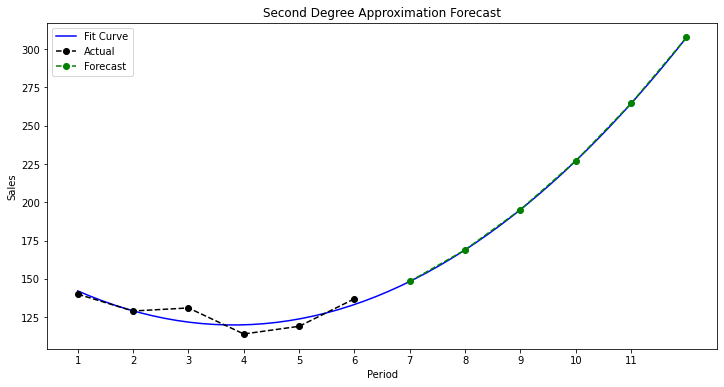

In [ ]:
# Create plot to display historic and forecasted data
forecast_window = 6

# Create dataset to plot the curve-fit polynomial
tst_x = np.linspace(1, periods_7 + forecast_window, 50)
tst_y = a + b*tst_x + c*tst_x**2

# Plot actual and forecast data vs. polynomial
plt.figure(figsize=(12, 6));
plt.plot(tst_x, tst_y, 'b-', label='Fit Curve');
plt.plot(x_7, y_7, 'ko--', label='Actual');
plt.plot(per[:forecast_window], second_degree_approximation[:forecast_window], 'go--', label='Forecast');
plt.xticks(list(range(1, periods_7 + forecast_window)));
plt.title('Second Degree Approximation Forecast');
plt.xlabel('Period');
plt.ylabel('Sales');
plt.legend();

## <a name="flexiblemethod"></a>Method 8: Flexible Method

This method is similar to Method 1 (percent over last year) as it is also applying a static growth rate to historic sales. However, instead of using the same period historically to generate the forecasted period (January 2019 to forecast January 2020), the user specifies a given number of periods to go back as the starting point to grow the forecast from.

In the example below, the period is 4, so the first forecast period (January) is generated by applying the 10% growth rate to the September sales figure (which is 4 months prior). The second forecast period applies the 10% growth rate to October, and so forth, to create the entire forecast period.

In [ ]:
percent_8 = Decimal(10)
periods_8 = 4

flexible_method = one_year_ago[-periods_8:]

# Generate forecast
for i in range(12):
    flexible_method.append(flexible_method[i] * (1 + percent_8 / 100))

# Remove the historical data needed for the first several forecast period calcs
del flexible_method[:periods_8]

flexible_method

[Decimal('144.1'),
 Decimal('125.4'),
 Decimal('130.9'),
 Decimal('150.7'),
 Decimal('158.51'),
 Decimal('137.94'),
 Decimal('143.99'),
 Decimal('165.77'),
 Decimal('174.361'),
 Decimal('151.734'),
 Decimal('158.389'),
 Decimal('182.347')]

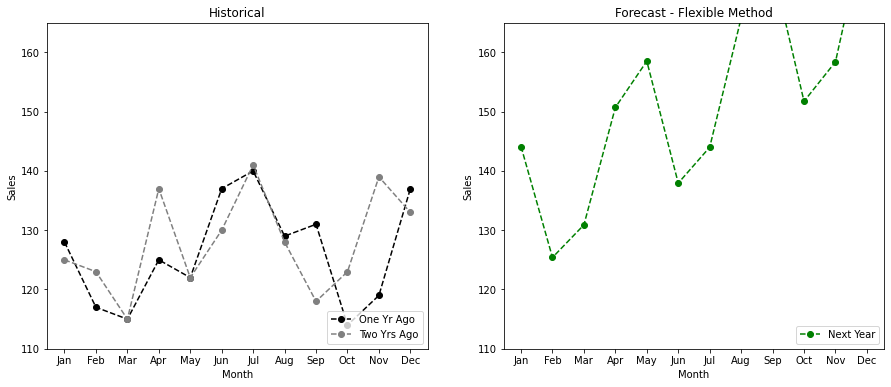

In [ ]:
make_plots(flexible_method, 'Flexible Method')

## <a name="weightedmovingaverage"></a>Method 9: Weighted Moving Average

Similar to the moving average method, this method calculates a weighted average over the given time period to generate the forecast data. The user supplies the number of periods to use in the average as well as how much to weight each period. The given weights must sum to 1.

The example below assumes a 4-period (month) window to calculate the moving average. The weights assign a 10% importance to the most distant period within that 4-month window, then 15% to the third-most recent period, then 25%, and finally 50% weight to the most recent period.

In [ ]:
periods_9 = 4
weights_9 = np.array([0.10, 0.15, 0.25, 0.50])
assert sum(weights_9) == 1

weighted_moving_average = one_year_ago[-periods_9:]

# Generate forecast
for i in range(12):
    weighted_moving_average.append(sum(weights_9 * np.array(weighted_moving_average[i:i + periods_9])))

# Remove the historical data needed for the first several forecast period calcs
del weighted_moving_average[:periods_9]

weighted_moving_average = [Decimal(n) for n in weighted_moving_average]
weighted_moving_average

[Decimal('128.44999999999998863131622783839702606201171875'),
 Decimal('127.724999999999994315658113919198513031005859375'),
 Decimal('128.42500000000001136868377216160297393798828125'),
 Decimal('129.111250000000012505552149377763271331787109375'),
 Decimal('128.665625000000005684341886080801486968994140625'),
 Decimal('128.6468750000000227373675443232059478759765625'),
 Decimal('128.69903125000001864464138634502887725830078125'),
 Decimal('128.72220312500002137312549166381359100341796875'),
 Decimal('128.699453125000019326762412674725055694580078125'),
 Decimal('128.6998195312500001818989403545856475830078125'),
 Decimal('128.70300664062500572981662116944789886474609375'),
 Decimal('128.7035964843749979991116560995578765869140625')]

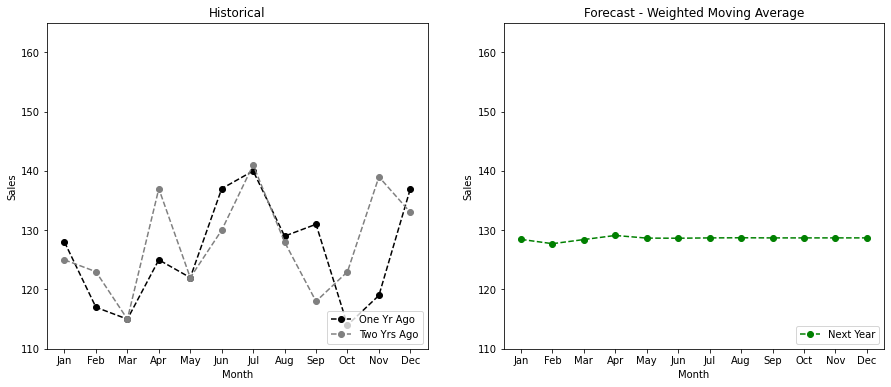

In [ ]:
make_plots(weighted_moving_average, 'Weighted Moving Average')

## <a name="linearsmoothing"></a>Method 10: Linear Smoothing

Similar to the weighted moving average method, this method applies a calculated, linearly increasing set of weights to historical data to generate the forecast data. The number of periods $n$ determines the total weight $W = \frac{(n^2 + n)}{2}$, then the least recent period of historical data starts with weight $\frac{1}{W}$, linearly increasing through the most recent period with weight $\frac{n}{W}$.

The example below uses a period of $n=4$, therefore $W = \frac{(4^2 + 4)}{2} = \frac{20}{2} = 10$ and each prior period's weights are:

| Period    | Weight    |
|-----------|-----------|
| September | 1/10      |
| October   | 2/10      |
| November  | 3/10      |
| December  | 4/10      |
| **Total** | **10/10** |

In [ ]:
periods_10 = 4

# Calculate the linearly-increasing weights
W = (periods_10**2 + periods_10) / 2
weights_10 = np.array([n / W for n in range(1, periods_10 + 1)])
assert sum(weights_10) == 1

linear_smoothing = one_year_ago[-periods_10:]

# Generate forecast
for i in range(12):
    linear_smoothing.append(sum(weights_10 * np.array(linear_smoothing[i:i + periods_10])))

# Remove the historical data needed for the first several forecast period calcs
del linear_smoothing[:periods_10]

linear_smoothing = [Decimal(n) for n in linear_smoothing]
linear_smoothing

[Decimal('126.400000000000005684341886080801486968994140625'),
 Decimal('126.8600000000000136424205265939235687255859375'),
 Decimal('127.96399999999999863575794734060764312744140625'),
 Decimal('128.223600000000004683897714130580425262451171875'),
 Decimal('127.690640000000001919033820740878582000732421875'),
 Decimal('127.822136000000000422005541622638702392578125'),
 Decimal('127.877166399999993018354871310293674468994140625'),
 Decimal('127.857995359999989659627317450940608978271484375'),
 Decimal('127.8398392639999912034909357316792011260986328125'),
 Decimal('127.8509811935999778143013827502727508544921875'),
 Decimal('127.8516599686399786151014268398284912109375'),
 Decimal('127.8497257343359905235047335736453533172607421875')]

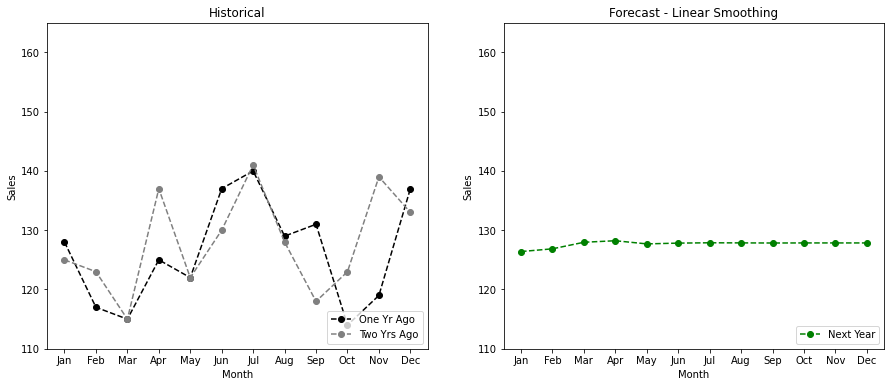

In [ ]:
make_plots(linear_smoothing, 'Linear Smoothing')

## <a name="exponentialsmoothing"></a>Method 11: Exponential Smoothing

The exponential smoothing method is related to the weighted average and linear smoothing methods. However, the weighted average method uses static, user-defined weights, and the linear smoothing method uses weights that linearly decline for older data. Instead, this method generates weights that *exponentially decay* the "less recent" the sales data is to the current forecast period.

The exponential decay formula that generates the weights has a 'smoothing' parameter called alpha ($\alpha$) that falls between 0 and 1. The closer that $\alpha$ is to 1, the more weight applies to older data ($D$ in the formulas below). The lower the $\alpha$ value, the more weight applies to recent smoothed periods ($S$ in the formulas below).

Where:

- $D$ is data (sales) for the appropriate time period
- $\alpha$ is the smoothing parameter
- $t$ is current time period
- $S$ is the smoothed data
- $F$ is forecasted data (sales)

$S_1 = D_0$  
$S_2 = \alpha (D_1) + (1 - \alpha) (S_1)$  
$S_{t} = \alpha (D_{t-1}) + (1 - \alpha) (S_{t-1})$

The example below uses a period of 4, which is September-December of the prior year. The first smoothed period is for October, since it needs the prior period's (September's) actual sales. Then the formulas above are applied for November and December. The December value is held flat and used to generate all forecast period sales.

$S_{\text{Oct}} = D_{\text{Sep}}$  
$S_{\text{Nov}} = \alpha (D_{\text{Oct}}) + (1 - \alpha) (S_{\text{Oct}})$  
$S_{\text{Dec}} = \alpha (D_{\text{Nov}}) + (1 - \alpha) (S_{\text{Nov}})$  
$F_1 = S_{\text{Dec}}$  
$F_2 = S_{\text{Dec}}$


In [ ]:
periods_11 = 4
alpha_11 = 0.3

smoothed_11 = [one_year_ago[-periods_11]]  # September actual
tmp = one_year_ago[-periods_11 + 1:]  # Oct-Dec of actual data

# Perform smoothing calculations
for i, sales in enumerate(tmp):
    smoothed_11.append(alpha_11 * sales + (1 - alpha_11) * smoothed_11[i])

print(f'Smoothed historical data: {smoothed_11}')

# Generate forecast
exponential_smoothing = [Decimal(smoothed_11[-1])] * 12

exponential_smoothing

Smoothed historical data: [131, 125.89999999999998, 123.82999999999998, 127.78099999999998]


[Decimal('127.780999999999977490006131120026111602783203125'),
 Decimal('127.780999999999977490006131120026111602783203125'),
 Decimal('127.780999999999977490006131120026111602783203125'),
 Decimal('127.780999999999977490006131120026111602783203125'),
 Decimal('127.780999999999977490006131120026111602783203125'),
 Decimal('127.780999999999977490006131120026111602783203125'),
 Decimal('127.780999999999977490006131120026111602783203125'),
 Decimal('127.780999999999977490006131120026111602783203125'),
 Decimal('127.780999999999977490006131120026111602783203125'),
 Decimal('127.780999999999977490006131120026111602783203125'),
 Decimal('127.780999999999977490006131120026111602783203125'),
 Decimal('127.780999999999977490006131120026111602783203125')]

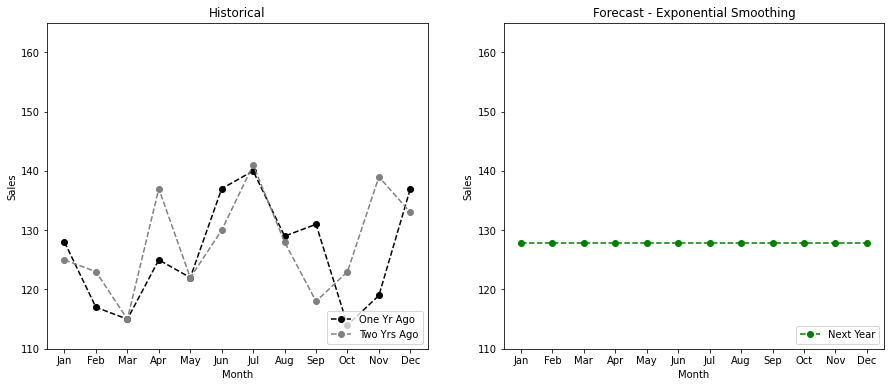

In [ ]:
make_plots(exponential_smoothing, 'Exponential Smoothing')

## <a name="expsmoothingwtrend"></a>Method 12: Exponential Smoothing with Trend and Seasonality

This method calculates a trend, a seasonal index, and an exponentially smoothed average from the historical sales data. It applies the trend to project the forecast, then adjusts that for the seasonal index.

The method has two smoothing parameters alpha ($\alpha$) and beta ($\beta$), where $\alpha$ is the smoothing factor for the level of sales and $\beta$ is the smoothing factor for the trend component.

Where:

- $D$ is data (sales) for the appropriate time period
- $L$ is length of seasonality (12 months or 52 weeks)
- $t$ is current time period
- $m$ is the number of time periods into the future of the forecast
- $S$ is the multiplicative seasonal adjustment factor that is indexed to the appropriate time period
- $A$ is the exponentially smoothed sales data - it's the seasonal-adjusted actual sales from time period $t$, averaged with the trend-adjusted prior period $A_{t-1}$
- $T$ is the exponentially smoothed trend factor - it's the difference of the current and prior smoothed sales data ($A$'s), averaged with the trend from the prior period ($T_{t-1}$)
- $F$ is the forecasted data (sales), which builds off $t=12$ averaged sales and trend factor, and applies the one year prior seasonality index

$S_t = \Big[(D_{t-L} + D_{t-2L}) / \sum_{n=t-2L}^{t-1} D-n \Big] \times L$  
$A_t = \alpha (D_t / S_{t-L}) + (1 - \alpha)(A_{t-1} + T_{t-1})$  
$T_t = \beta (A_t - A_{t-1}) + (1 - \beta) T_{t-1}$  
$F_{t+m} = (A_t + T_t * m) S_{t-L+m}$

Once smoothing is applied to the historical data, the forecast is generated by extrapolating the latest value to generate the forecast data.

In [ ]:
periods_12 = 4
L_12 = 12
alpha_12 = 0.3
beta_12 = 0.4

# Calculate seasonality indices
all_sales = sum(one_year_ago) + sum(two_years_ago)
seasonality_12 = [(sales_1yrago + two_years_ago[i]) / all_sales * L_12
                  for i, sales_1yrago in enumerate(one_year_ago)]
# print(f'Seasonality Indices: {seasonality_12:.4f}')

# Initialize A_1 and T_1
averages_12 = [one_year_ago[0] / seasonality_12[0]]  # Jan sales / Jan seasonality index
trends_12 =[0]

# Calculate remaining smoothed averages A and trend factors T
for i in range(1, 12):
    A_t = alpha_12 * (one_year_ago[i] / seasonality_12[i]) + (1 - alpha_12) * (averages_12[i-1] + trends_12[i-1])
    T_t = beta_12 * (A_t - averages_12[i-1]) + (1 - beta_12) * (trends_12[i-1])
    averages_12.append(A_t)
    trends_12.append(T_t)

for i in range(12):
    print(f'{cols[i]}')
    print(f'S index: {seasonality_12[i]:.4f}')
    print(f'A_{i+1}: {averages_12[i]:.2f}')
    print(f'T_{i+1}: {trends_12[i]:.2f}')
    print('-'*20)

Jan
S index: 0.9961
A_1: 128.51
T_1: 0.00
--------------------
Feb
S index: 0.9449
A_2: 127.10
T_2: -0.56
--------------------
Mar
S index: 0.9055
A_3: 126.68
T_3: -0.51
--------------------
Apr
S index: 1.0315
A_4: 124.67
T_4: -1.11
--------------------
May
S index: 0.9606
A_5: 124.60
T_5: -0.69
--------------------
Jun
S index: 1.0512
A_6: 125.83
T_6: 0.08
--------------------
Jul
S index: 1.1063
A_7: 126.10
T_7: 0.15
--------------------
Aug
S index: 1.0118
A_8: 126.63
T_8: 0.30
--------------------
Sep
S index: 0.9803
A_9: 128.94
T_9: 1.11
--------------------
Oct
S index: 0.9331
A_10: 127.69
T_10: 0.16
--------------------
Nov
S index: 1.0157
A_11: 124.64
T_11: -1.12
--------------------
Dec
S index: 1.0630
A_12: 125.13
T_12: -0.48
--------------------


In [ ]:
# Generate forecast
exponential_smoothing_trend_seasonality = []

for m in range(1, 13):
    F = (averages_12[-1] + trends_12[-1] * m) * seasonality_12[m-1]
    exponential_smoothing_trend_seasonality.append(F)

exponential_smoothing_trend_seasonality = [Decimal(n) for n in exponential_smoothing_trend_seasonality]
exponential_smoothing_trend_seasonality

[Decimal('124.159961769834211509078158996999263763427734375'),
 Decimal('117.3291585691920175804625614546239376068115234375'),
 Decimal('112.0081947395869264028078760020434856414794921875'),
 Decimal('127.0995557078068856071695336140692234039306640625'),
 Decimal('117.908965471821005621677613817155361175537109375'),
 Decimal('128.5215505878383055460290051996707916259765625'),
 Decimal('134.732412914514299018264864571392536163330078125'),
 Decimal('122.7420270670584869776575942523777484893798828125'),
 Decimal('118.4533071724319057693719514645636081695556640625'),
 Decimal('112.29930976548979515428072772920131683349609375'),
 Decimal('121.7650110237349139197249314747750759124755859375'),
 Decimal('126.9210772994729694573834422044456005096435546875')]

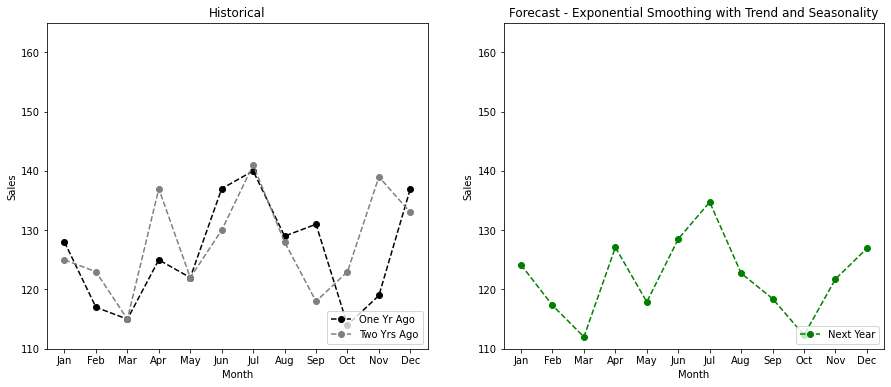

In [ ]:
make_plots(exponential_smoothing_trend_seasonality, 'Exponential Smoothing with Trend and Seasonality')